# Setup

In [1]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))
options(jupyter.plot_scale = 1.5)
options(warn = -1)
require("pacman")
pacman::p_load(tidyverse, lubridate, zoo, ggpubr, ggfortify, forecast)

source('../Scripts/ReadData.R')
source('../Scripts/ModelSelection.R')
source('../Scripts/ResidualAnalysis.R')
source('../Scripts/Forecasting.R')

Loading required package: pacman



# Exploration

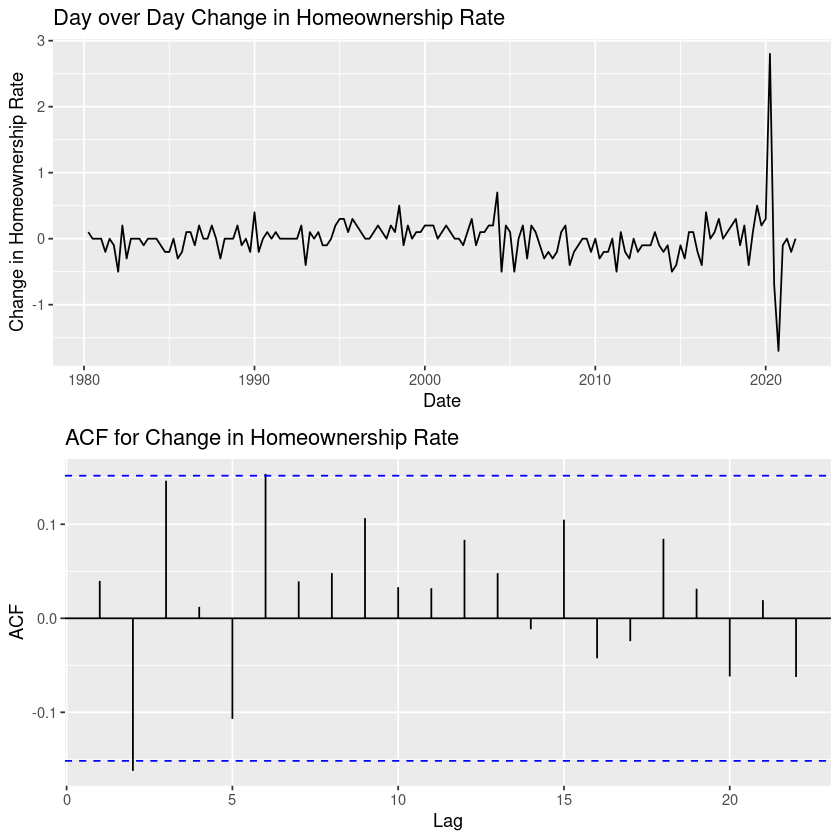

In [2]:
homeownership <- read_homeownership()
homeownership_diff <- homeownership %>% mutate(dValue = Value - lag(Value)) %>% drop_na %>% select(-Value)

p1 <- homeownership_diff %>% ggplot() +
    geom_line(aes(x = Date, y = dValue)) +
    labs(y = "Change in Homeownership Rate", title = "Day over Day Change in Homeownership Rate")
p2 <- ggAcf(homeownership_diff$dValue) + 
    labs(title = "ACF for Change in Homeownership Rate")
ggarrange(p1, p2, nrow = 2, ncol = 1)

# Training ARIMA

In [3]:
test_split = 4
train <- head(homeownership_diff, -test_split)
test <- tail(homeownership_diff, test_split)

In [4]:
arima_comp <- find_best_arima(train$dValue, 0:5, 0:2, 0:5)
head(arima_comp)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,4,0,4,86.75047
2,5,1,5,91.42036
3,5,1,1,92.86274
4,5,1,2,94.36783
5,3,0,3,95.55478
6,2,1,4,95.75151



	Box-Ljung test

data:  residuals(model)
X-squared = 2.2186, df = 1, p-value = 0.1364


	Box-Ljung test

data:  residuals(model)^2
X-squared = 3.5294, df = 1, p-value = 0.06029



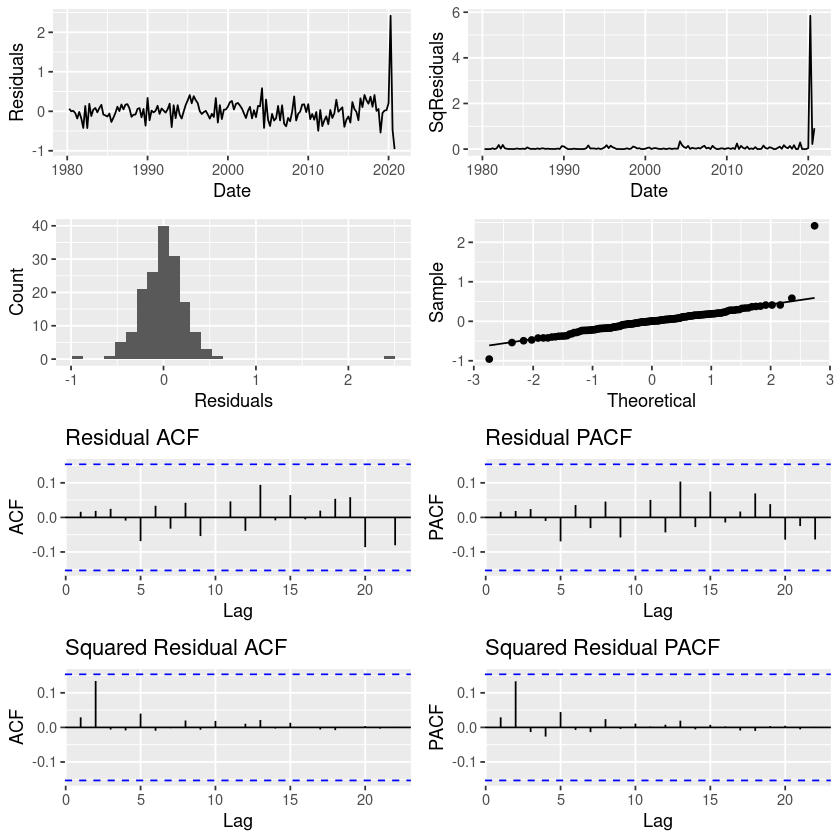

In [5]:
best_order <- as.numeric(arima_comp[1,1:3])
arima_model <- arima(train$dValue, order = best_order, method = "ML", optim.control = list(maxit = 1000))
residual_analysis(arima_model, train$Date)
box_tests(arima_model, best_order[1] + best_order[3])

# Training ARMA-GARCH

In [6]:
ugarch_comp <- find_best_ugarch(homeownership_diff$dValue, best_order[1], best_order[3], 0:5, 0:5, 0:2, 0:2, test_size = test_split)
head(ugarch_comp$Final)

,p,q,m,n,BIC
,<int>,<int>,<int>,<int>,<dbl>
1,3,3,1,0,-0.109852754
2,3,3,0,1,-0.020908051
3,3,3,1,1,-0.015872102
4,3,3,2,0,-0.012585523
5,3,3,0,0,-0.004413106
6,3,3,1,2,0.015272562


## Model 1: Best orders


	Box-Ljung test

data:  residuals(model)
X-squared = 23.217, df = 1, p-value = 1.447e-06


	Box-Ljung test

data:  residuals(model)^2
X-squared = 36.133, df = 1, p-value = 1.843e-09



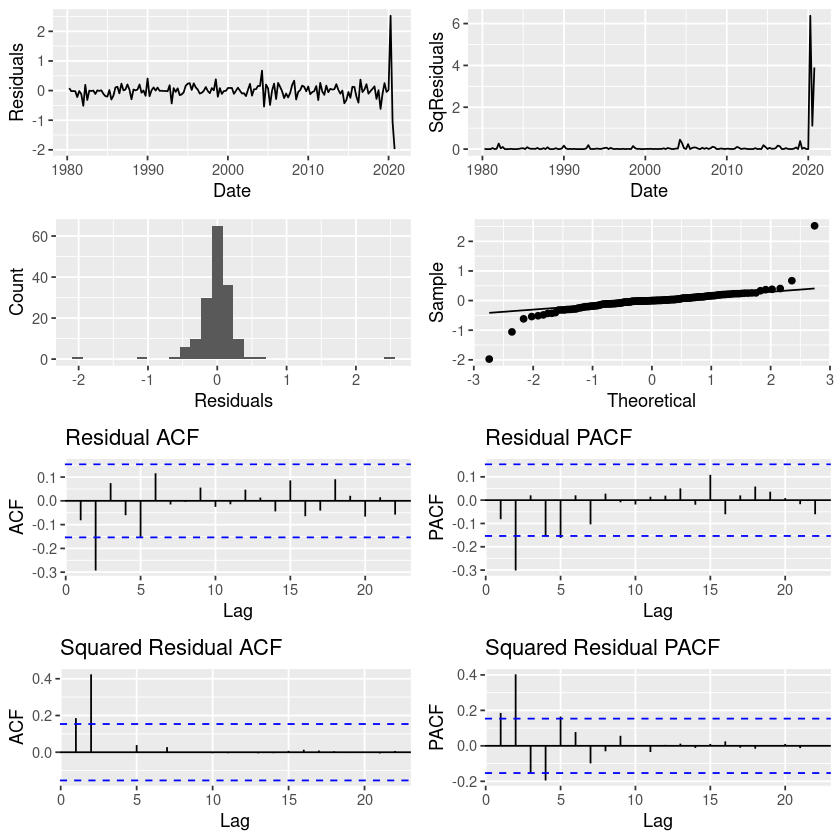

In [7]:
best_order <- ugarch_comp$Final[1,1:4] %>% as.numeric
spec1 <- ugarchspec(variance.model=list(garchOrder=c(best_order[3:4])),
                     mean.model=list(armaOrder=c(best_order[1:2]),
                                     include.mean=T), distribution.model="std")
ugarch_model1 <- ugarchfit(spec1, homeownership_diff$dValue, solver = 'hybrid', out.sample = test_split)
residual_analysis(ugarch_model1, train$Date)
box_tests(ugarch_model1, sum(best_order))

## Model 2: Forced GARCH(1,1)


	Box-Ljung test

data:  residuals(model)
X-squared = 17.005, df = 1, p-value = 3.727e-05


	Box-Ljung test

data:  residuals(model)^2
X-squared = 36.841, df = 1, p-value = 1.282e-09



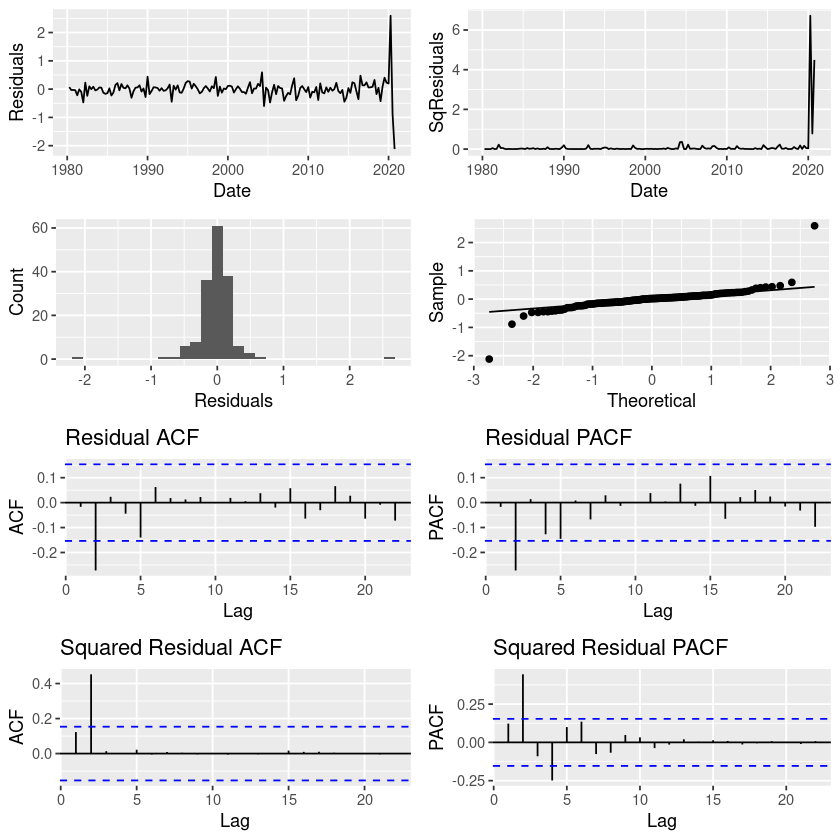

In [8]:
spec2 <- ugarchspec(variance.model=list(garchOrder=c(1,1)),
                     mean.model=list(armaOrder=c(best_order[1:2]),
                                     include.mean=T), distribution.model="std")
ugarch_model2 <- ugarchfit(spec2, homeownership_diff$dValue, solver = 'hybrid', out.sample = test_split)
residual_analysis(ugarch_model2, train$Date)
box_tests(ugarch_model2, sum(best_order[1:2])+2)

# Forecasting

## ARIMA

PM =  90.87818

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.5155736,0.790435,0.736569,-Inf,Inf


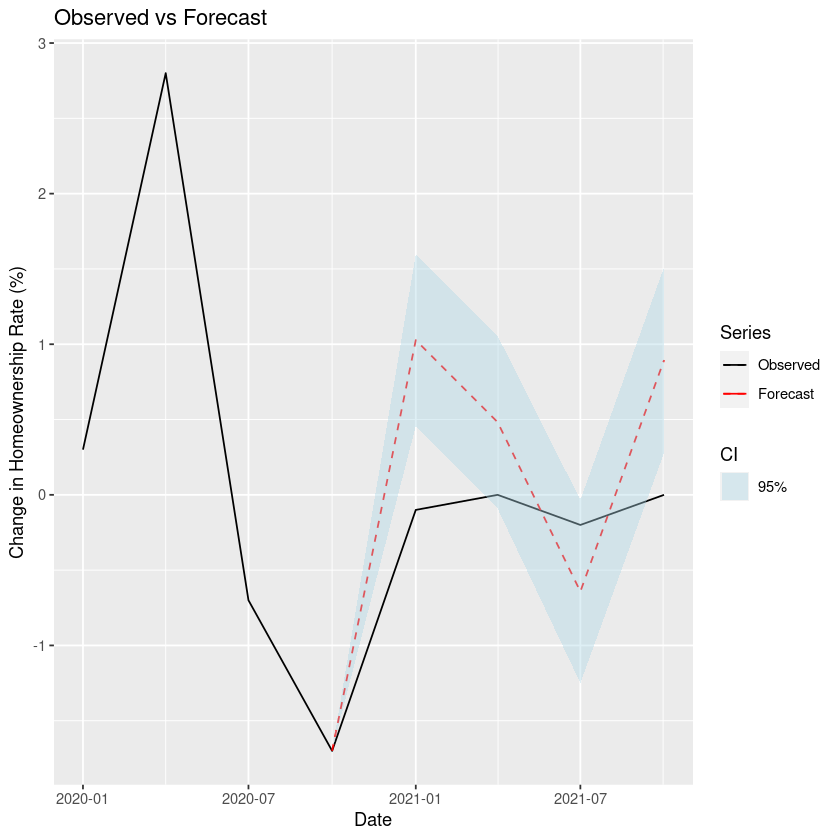

In [9]:
fc <- forecast_arima(arima_model, homeownership_diff$Date, homeownership_diff$dValue, test_split, 95,
                    y_lab = "Change in Homeownership Rate (%)")
fc$plot
fc_data <- tail(fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

## ARMA-GARCH: Model 1

PM =  23.80738

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.4003836,0.4045686,0.4003836,-Inf,Inf


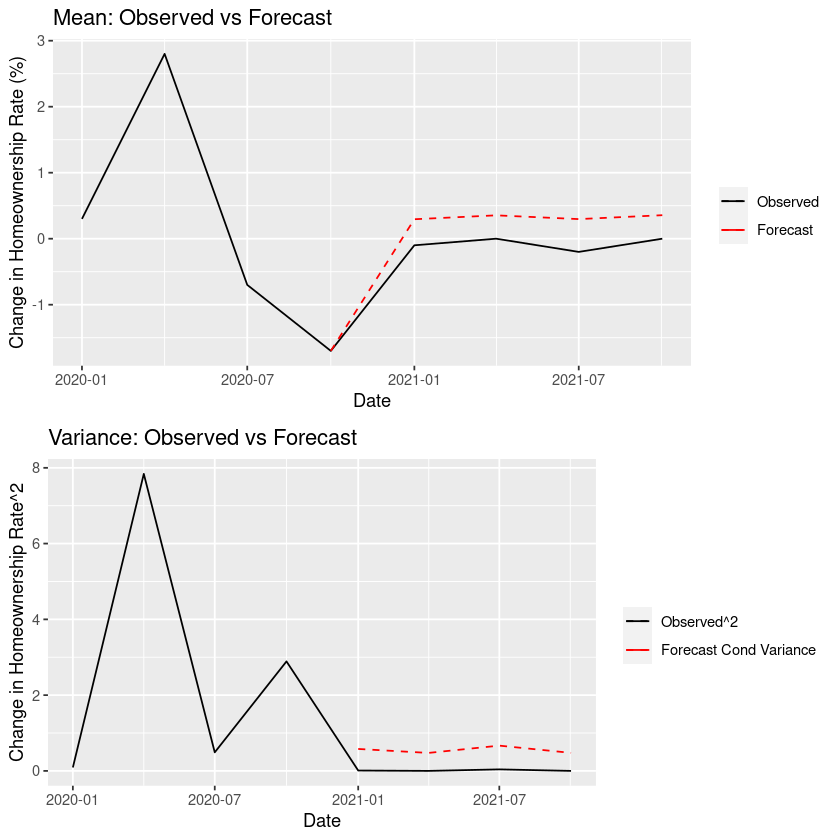

In [10]:
fc <- forecast_ugarchroll(ugarch_model1, homeownership_diff$Date, test$dValue, test_split,
                          y_lab = c("Change in Homeownership Rate (%)", "Change in Homeownership Rate^2"))
fc$plot
fc_data <- tail(fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

## ARMA-GARCH: Model 2

PM =  15.28858

,ME,RMSE,MAE,MPE,MAPE
Test set,0.01247705,0.3242051,0.2833181,Inf,Inf


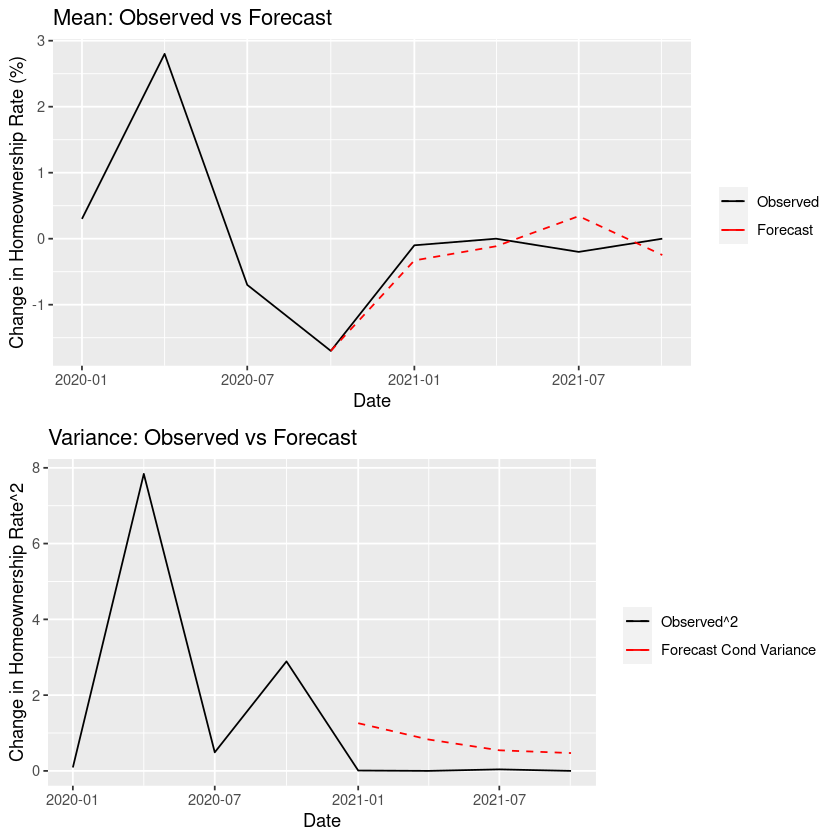

In [11]:
fc <- forecast_ugarchroll(ugarch_model2, homeownership_diff$Date, test$dValue, test_split,
                          y_lab = c("Change in Homeownership Rate (%)", "Change in Homeownership Rate^2"))
fc$plot
fc_data <- tail(fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)